# TESTING

In [2]:
from utils import *
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.covariance import empirical_covariance

import matplotlib.pyplot as plt

N = 5

data = prepare_mnist_data()
trainX = data['trainX']
trainY = data['trainY']

unique, counts = np.unique(trainY, return_counts=True)
for u,c in zip(unique,counts):
    print(f"class {u}: instances {c}")

def Covariance(X,y):
    N_features = X.shape[1]
    cov_vec = np.zeros(N_features)
    for i in range(X.shape[1]):
        x_i = X[:,i]
        xbar, ybar = x_i.mean(), y.mean()
        cov_vec[i] = np.sum((x_i-xbar)*(y-ybar))/(len(x_i)-1)
    return cov_vec

class 0.0: instances 327
class 3.0: instances 356
class 4.0: instances 317


**CLUSTERING**

(784,)
0.30447099999998545
0.30447100000000005
9497.502784000053


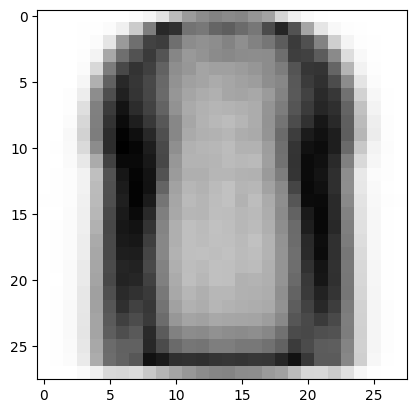

In [4]:
foo = np.var(trainX, axis=0)
print(foo.shape)
print(foo[0])
print(np.var(trainX[:,0]))
print(max(foo))

plt.imshow(np.reshape(foo, (28,28)), cmap=plt.get_cmap('Greys'), interpolation='nearest')
plt.show()

**CLASSIFICATION**

In [5]:
# Get dataset unique labels and the sample indices corresponding to those labels
from gekko import GEKKO

unique_labels = np.unique(trainY)
indices_per_label = []
for i, label in enumerate(unique_labels):
    indices = np.where(trainY == label)
    indices_per_label.append(indices)

num_features = 50

# Assume no access to itertools, just use the known possible pairs given the fashion mnist dataset
label_pairs = ((0,1), (0,2), (1,2))

pairwise_covariances = []

# Iterate across all potential label pairs
for (lbl_idx_a, lbl_idx_b) in label_pairs:
    lbl_a = unique_labels[lbl_idx_a]
    lbl_b = unique_labels[lbl_idx_b]

    # Combine sample indices from both classes
    indices = np.append(indices_per_label[lbl_idx_a], indices_per_label[lbl_idx_b])

    # Get X and Y samples from the indices
    X_prime = np.take(trainX, indices, axis=0)
    Y_prime = np.take(trainY, indices)
    
    # print(X_prime.shape)
    # print(Y_prime.shape)

    # relabel original class labels to -1, +1
    for i in range(len(Y_prime)):
        if Y_prime[i] == lbl_a:
            Y_prime[i] = 1
        elif Y_prime[i] == lbl_b:
            Y_prime[i] = -1
    
    # compute covariance for the pair of labels
    pair_covariance = Covariance(X_prime, Y_prime)
    pairwise_covariances.append(np.absolute(pair_covariance))

    # constraints = LinearConstraint
    # selection = cvxpy.Variable(trainX.shape[1])

    # variable = cvxpy.

feature_counts = [5, 20, 80, 320, 784]
selected_features = {}

for feature_count in feature_counts:
    mdl = GEKKO(remote=False)

    # Define max features
    K = mdl.Const(feature_count)

    # Define covariance vector constants
    z_0_1 = [mdl.Const(value=val) for val in pairwise_covariances[0]]
    z_0_2 = [mdl.Const(value=val) for val in pairwise_covariances[1]]
    z_1_2 = [mdl.Const(value=val) for val in pairwise_covariances[2]]

    # Define t_min auxiliary variable
    t_min = mdl.Var(value=0, lb=0)

    # Define pixel selection vector, with its integrality and 0/1 constraints
    s = [mdl.Var(value=0, lb=0, ub=1, integer=True) for i in range(trainX.shape[1])]

    print(len(s))
    # Define constraints
    ## Max number of pixels constraint
    mdl.Equation(np.sum(s) <= K)

    ## Set t_min to the min sum absolute covariance across all class pairs
    # mdl.Equation(t_min <= np.dot(s, z_0_1))
    # mdl.Equation(t_min <= np.dot(s, z_0_2))
    # mdl.Equation(t_min <= np.dot(s, z_1_2))
    ### Reformulate dot products as element-wise multiply and sum to avoid errors in GEKKO
    mdl.Equation(t_min <= mdl.sum([s_i*z_0_1_i for (s_i, z_0_1_i) in zip(s,z_0_1)]))
    mdl.Equation(t_min <= mdl.sum([s_i*z_0_2_i for (s_i, z_0_2_i) in zip(s,z_0_2)]))
    mdl.Equation(t_min <= mdl.sum([s_i*z_1_2_i for (s_i, z_1_2_i) in zip(s,z_1_2)]))

    # Set objective function to maximize t_min
    mdl.Maximize(t_min)
    mdl.options.MAX_ITER = 10000
    mdl.options.SOLVER = 1    
    mdl.options.IMODE = 3
    mdl.solve(disp=True)

    selected_features[feature_count] = np.array([s_i.value for s_i in s])

784
 ----------------------------------------------------------------
 APMonitor, Version 1.0.3
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :  3
   Constants    :  2353
   Variables    :  3144
   Intermediates:  0
   Connections  :  2355
   Equations    :  2357
   Residuals    :  2357
 
 Number of state variables:    3144
 Number of total equations: -  2359
 Number of slack variables: -  4
 ---------------------------------------
 Degrees of freedom       :    781
 
 ----------------------------------------------
 Steady State Optimization with APOPT Solver
 ----------------------------------------------
Iter:     1 I:  0 Tm:      0.42 NLPi:    5 Dpth:    0 Lvs:    3 Obj: -2.34E+02 Gap:       NaN
--Integer Solution:  -2.20E+02 Lowest Leaf:  -2.34E+02 Gap:   6.11E-02
Iter:     2 I:  0 Tm:      0.38 NLPi:   14 Dpth:    1 Lvs:    2 Obj: -2.20E+02 Gap:  6.

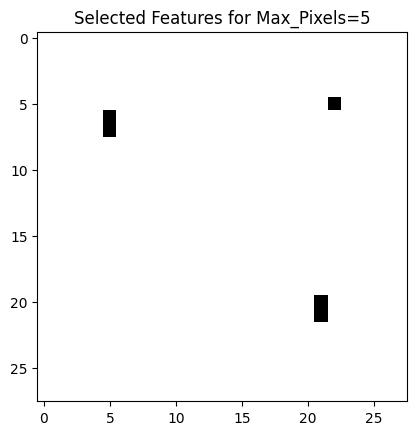

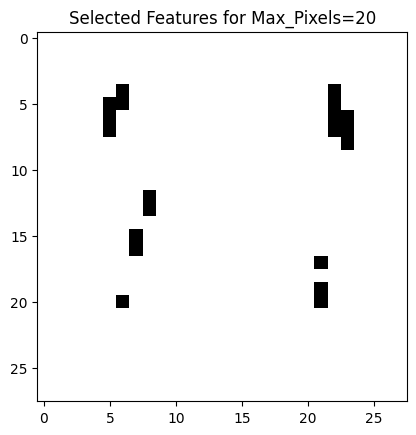

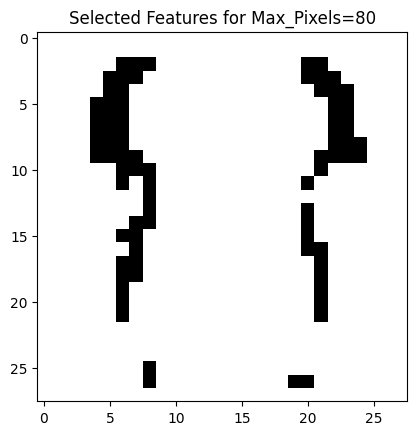

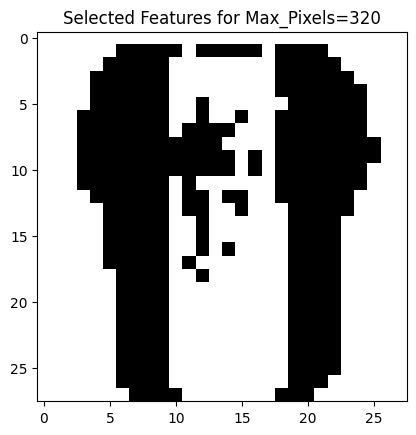

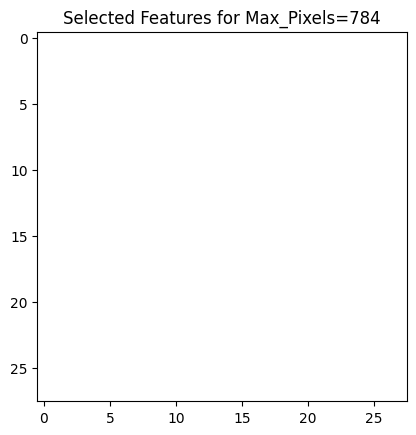

In [6]:
for feature_count in feature_counts:
    plt.imshow(np.reshape(selected_features[feature_count], (28,28)), cmap=plt.get_cmap('Greys'), interpolation='nearest')
    plt.title(f"Selected Features for Max_Pixels={feature_count}")
    plt.show()